Poniżej masz kompletny odpowiednik Twojego laboratorium w **Pythonie** (w formie „notatek” + gotowych bloków kodu).
Użyte biblioteki: `numpy`, `pandas`, `matplotlib`, `scipy`, `statsmodels`.
Wszystkie wykresy rysowane są w `matplotlib`; ACF – w `statsmodels`.

---

# Analiza szeregów czasowych M.S. — LAB 1 (Python)

## Instalacja (jeśli potrzeba)

```bash
pip install numpy pandas matplotlib scipy statsmodels
```

---

## Importy i podstawowe ustawienia wykresów

```python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import skew, kurtosis
from statsmodels.graphics.tsaplots import plot_acf

plt.rcParams.update({
    "figure.figsize": (9, 4.8),
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False
})
np.random.seed(123)  # dla powtarzalności
```

---

## TEMAT 1. Generatory liczb (pseudo)losowych

### a) Rozkład dwumianowy b(n, p)

```python
N = 100
n = 10
p = 0.5

x1 = np.random.binomial(n=n, p=p, size=N)
print(x1)

# średnia i wariancja: próbkowe vs. teoretyczne
print("Sample mean/var:", np.mean(x1), np.var(x1, ddof=1))
print("Theoretical mean/var:", n*p, n*p*(1-p))

plt.plot(x1, marker='o', linestyle='none')
plt.xlabel("i"); plt.ylabel("X(i)")
plt.title("Próba dwumianowa b(n,p)")
plt.show()
```

### b) Rozkład Poissona

```python
N = 100
lam = 5

x2 = np.random.poisson(lam=lam, size=N)
print("Sample mean/var:", np.mean(x2), np.var(x2, ddof=1))
```

### c) Rozkład normalny

```python
N = 500
m = 2
s = 3

x3 = np.random.normal(loc=m, scale=s, size=N)

plt.hist(x3, bins=30)
plt.title("Histogram próby gaussowskiej")
plt.show()

print("mean, sd, Q1, Q3:")
print(np.mean(x3), np.std(x3, ddof=1), np.quantile(x3, 0.25), np.quantile(x3, 0.75))
from scipy.stats import norm
print("theoretical Q1,Q3:", norm.ppf([0.25, 0.75], loc=m, scale=s))
```

> Inne generatory (odpowiedniki R):
> `np.random.geometric`, `np.random.negative_binomial`, `np.random.uniform`, `np.random.exponential`, `np.random.standard_t`, `np.random.chisquare`, `np.random.f`, `np.random.gamma`, `np.random.beta`, `np.random.weibull`, `np.random.lognormal`, itp.
> Odpowiednik `sample()` → `np.random.choice`.

---

## TEMAT 1. Błądzenie losowe (random walk)

```python
# czyścimy „stan” – w Pythonie po prostu nadpisujemy zmienne
n = 500
p = 0.5
t = np.arange(1, n+1)
```

### a) Sposób 1: z rbinom → {0,1} → {−1,+1}

```python
Yt = np.random.binomial(n=1, p=p, size=n)
Xt = 2*Yt - 1
St = np.cumsum(Xt)

plt.plot(t, St, lw=2)
plt.axhline(0, color='k', lw=1)
plt.xlabel("t"); plt.ylabel("{S(t)}")
plt.title("Trajektoria błądzenia losowego (sposób 1)")
plt.show()
```

### b) Sposób 2: losowanie bezpośrednio z {−1, +1}

```python
rt = np.random.choice([1, -1], size=n, replace=True, p=[p, 1-p])
S2t = np.cumsum(rt)

plt.plot(t, S2t, lw=2)
plt.axhline(0, color='k', lw=1)
plt.xlabel("t"); plt.ylabel("{S(t)}")
plt.title("Trajektoria błądzenia losowego (sposób 2)")
plt.show()
```

### Porównanie dwóch trajektorii

```python
m_ = np.minimum(St.min(), S2t.min())
M_ = np.maximum(St.max(), S2t.max())

plt.plot(t, St, lw=2, label="Trajektoria 1")
plt.plot(t, S2t, lw=2, label="Trajektoria 2")
plt.ylim(m_, M_)
plt.axhline(0, color='k', lw=1)
plt.legend(loc="upper left")
plt.xlabel("t"); plt.ylabel("S(t)")
plt.title("Dwie trajektorie błądzenia losowego")
plt.show()
```

---

## TEMAT 1. Proces ceny ze zwrotów {r(t)} (drzewko dwumianowe)

### a) Zwroty arytmetyczne

```python
n = 100
p = 0.5
rt = np.random.choice([0.01, -0.01], size=n, replace=True, p=[p, 1-p])
P0 = 200
t = np.arange(0, n+1)

P1t = np.concatenate([[P0], P0 * np.cumprod(1 + rt)])

plt.plot(t, P1t, lw=2)
plt.axhline(P0, ls='--', color='r')
plt.xlabel("t"); plt.ylabel("{P(t)}")
plt.title("Trajektoria {P(t)} ze zwrotów arytmetycznych")
plt.show()
```

### b) Zwroty logarytmiczne

```python
P2t = np.concatenate([[P0], P0 * np.exp(np.cumsum(rt))])

plt.plot(t, P2t, lw=2)
plt.axhline(P0, ls='--', color='r')
plt.xlabel("t"); plt.ylabel("{P(t)}")
plt.title("Trajektoria {P(t)} ze zwrotów logarytmicznych")
plt.show()
```

**Zadanie 1 (wspólny wykres):**

```python
m_ = min(P1t.min(), P2t.min())
M_ = max(P1t.max(), P2t.max())

plt.plot(t, P1t, lw=2, label="Arytmetyczne")
plt.plot(t, P2t, lw=2, label="Logarytmiczne")
plt.ylim(m_, M_)
plt.axhline(P0, ls='--', color='r')
plt.legend()
plt.xlabel("t"); plt.ylabel("{P(t)}")
plt.title("Porównanie: arytmetyczne vs logarytmiczne zwroty")
plt.show()
```

### c) „Drzewko wielomianowe” – wielopunktowy rozkład zwrotów (arytmetyczne)

```python
r_  = np.array([-0.045, -0.01, 0, 0.01, 0.06])
ps_ = np.array([0.3, 0.1, 0.2, 0.25, 0.15])
p_  = ps_ / ps_.sum()  # normalizacja

rt_ = np.random.choice(r_, size=n, replace=True, p=p_)
P0 = 200
t = np.arange(0, n+1)

Pt_ = np.concatenate([[P0], P0 * np.cumprod(1 + rt_)])

plt.plot(t, Pt_, lw=2)
plt.axhline(P0, ls='--', color='r')
plt.xlabel("t"); plt.ylabel("{P(t)}")
plt.title("Trajektoria {P(t)} – drzewko wielomianowe (arytmetyczne)")
plt.show()
```

**Zadanie 2 (logarytmiczne):**

```python
P2t_ = np.concatenate([[P0], P0 * np.exp(np.cumsum(rt_))])

plt.plot(t, P2t_, lw=2)
plt.axhline(P0, ls='--', color='r')
plt.xlabel("t"); plt.ylabel("{P(t)}")
plt.title("Trajektoria {P(t)} – drzewko wielomianowe (logarytmiczne)")
plt.show()
```

---

## TEMAT 2. Dane empiryczne, ACF, transformacje, obiekt „ts()” w wersji pandas

> Dane źródłowe: FRED „TTLCON — Total Construction Spending”.
> W R wczytujesz plik `TotalConstruction.txt`. W Pythonie zrobimy analogicznie: zakładam, że plik ma 2 kolumny (np. data i wartość). Jeśli separator to spacja/tab, użyj `delim_whitespace=True`. Jeśli to CSV – zmień na `sep=','`.

### 1) Wczytanie danych, wizualizacja, statystyki

```python
# PRZYKŁAD 1 — plik „kolumna_data kolumna_wydatki” rozdzielony spacją/tabem:
dane = pd.read_table("TotalConstruction.txt", delim_whitespace=True, header=None, names=["Data", "Wydatki"])

# PRZYKŁAD 2 — jeśli masz CSV z nagłówkami:
# dane = pd.read_csv("TotalConstruction.txt")  # i ewentualnie: names=["Data","Wydatki"]

dane.head()
Xt = dane["Wydatki"].astype(float).to_numpy()

print(pd.Series(Xt).describe())
print("sd, skewness, kurtosis(excess):",
      np.std(Xt, ddof=1),
      skew(Xt, bias=False),
      kurtosis(Xt, fisher=True, bias=False))

plt.plot(Xt, lw=2)
plt.xlabel("t"); plt.ylabel("{X(t)}")
plt.title("Wydatki na budownictwo w USA [mln USD]")
plt.show()
```

### 2) Próbkowy autokorelogram ACF

```python
H = 50

# ACF z lagiem 0:
plot_acf(Xt, lags=H)
plt.xlabel("h"); plt.ylabel("ACF(h)")
plt.title("Próbkowy autokorelogram dla {X(t)} (z lag=0)")
plt.show()

# „Lepsza” wersja bez ACF(0) – zero=False usuwa lag 0
plot_acf(Xt, lags=H, zero=False)
plt.xlabel("h"); plt.ylabel("ACF(h)")
plt.title("Próbkowy autokorelogram dla {X(t)} (bez lag=0)")
plt.show()
```

### 3) Podstawowe transformacje szeregu {X(t)}

#### a) Różnicowanie (przyrosty)

```python
Yt = np.diff(Xt)

plt.plot(Yt, lw=2)
plt.xlabel("t"); plt.ylabel("Y(t)")
plt.title("Przyrosty wydatków na budownictwo w USA [mln USD]")
plt.show()

plot_acf(Yt, lags=H)
plt.xlabel("h"); plt.ylabel("ACF(h)")
plt.title("ACF dla {Y(t)} (z lag=0)")
plt.show()

plot_acf(Yt, lags=H, zero=False)
plt.xlabel("h"); plt.ylabel("ACF(h)")
plt.title("ACF dla {Y(t)} (bez lag=0)")
plt.show()
```

#### b) Różnicowanie sezonowe z krokiem 12

```python
# jeśli Xt jest miesięczne:
Zt = Xt[12:] - Xt[:-12]   # równoważnik diff(Xt, lag=12)

plt.plot(Zt, lw=2)
plt.xlabel("t"); plt.ylabel("Z(t)")
plt.title("Różnicowanie sezonowe (lag=12)")
plt.show()

plot_acf(Zt, lags=H)
plt.xlabel("h"); plt.ylabel("ACF(h)")
plt.title("ACF dla {Z(t)} (z lag=0)")
plt.show()

plot_acf(Zt, lags=H, zero=False)
plt.xlabel("h"); plt.ylabel("ACF(h)")
plt.title("ACF dla {Z(t)} (bez lag=0)")
plt.show()
```

#### c) Różnicowanie sezonowe + zwykłe łącznie

```python
Vt = np.diff(Zt)  # najpierw sezonowe, potem zwykłe (jak w R: diff(diff(Xt,12),1))

plt.plot(Vt, lw=2)
plt.xlabel("t"); plt.ylabel("Z(t)-Z(t-1)")
plt.title("Dwukrotnie transformowane: sezonowe + zwykłe")
plt.show()

plot_acf(Vt, lags=H)
plt.xlabel("h"); plt.ylabel("ACF(h)")
plt.title("ACF dla {Z(t)-Z(t-1)} (z lag=0)")
plt.show()

plot_acf(Vt, lags=H, zero=False)
plt.xlabel("h"); plt.ylabel("ACF(h)")
plt.title("ACF dla {Z(t)-Z(t-1)} (bez lag=0)")
plt.show()
```

---

## 4) Obiekt „ts()”: w Pythonie → `pandas.Series` z datami i częstotliwością

Załóżmy, że dane są **miesięczne** i zaczynają się w **październiku 2006** (jak w R `start=c(2006,10), frequency=12`).

```python
# tworzymy indeks miesięczny startujący 2006-10, długość = len(Xt)
Xts = pd.Series(
    Xt,
    index=pd.date_range(start="2006-10-01", periods=len(Xt), freq="MS")  # MS = Month Start
)

Xts.plot(lw=2)
plt.xlabel("Czas"); plt.ylabel("X(t)")
plt.title("Szereg czasowy X(t) jako pandas.Series z DatetimeIndex")
plt.show()
```

### „Wycinanie” (window)

```python
# Wycinanie: od 2015-11 do 2019-05 (włącznie)
Xts2 = Xts.loc["2015-11":"2019-05"]

Xts2.plot(lw=2)
plt.xlabel("Czas"); plt.ylabel("X(t)")
plt.title("Wycinek szeregu X(t) — 2015-11 do 2019-05")
plt.show()
```

### Dane tylko z marca rok po roku

```python
Xts_march = Xts[Xts.index.month == 3]
print(Xts_march)
print(Xts_march.describe())
```

---

## Uwaga praktyczna – wczytywanie FRED TTLCON bezpośrednio

Jeśli w przyszłości zechcesz pobrać TTLCON prosto z FRED, wygodnie jest użyć pakietu `pandas-datareader` (wymaga klucza API FRED przy nowszych ustawieniach):

```python
# pip install pandas-datareader
import pandas_datareader.data as web

tt = web.DataReader("TTLCON", "fred")  # kolumna 'TTLCON', indeks dat
tt.plot(lw=2)
plt.title("FRED: TTLCON — Total Construction Spending")
plt.show()
```

---

Jeśli chcesz, mogę Ci też z tego zrobić gotowy plik `.py` lub notatnik `.ipynb`.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import skew, kurtosis
from statsmodels.graphics.tsaplots import plot_acf

plt.rcParams.update({
    "figure.figsize": (9, 4.8),
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False
})
np.random.seed(123)  # dla powtarzalności

[6 4 4 5 6 5 8 6 5 5 4 6 5 3 5 6 4 4 5 5 6 7 6 5 6 4 4 4 4 6 3 5 5 5 5 4 5
 7 7 5 6 3 4 5 7 4 5 8 5 5 3 6 5 5 4 4 5 6 7 5 6 5 6 6 7 3 6 4 4 5 3 7 6 6
 2 5 5 3 3 6 4 6 5 5 7 7 4 2 4 5 6 9 4 6 5 6 3 5 4 4]
Sample mean/var: 5.05 1.7045454545454544
Theoretical mean/var: 5.0 2.5


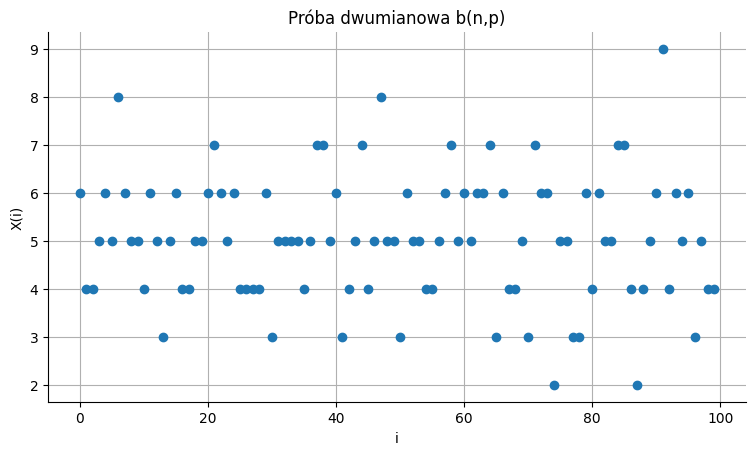

In [3]:
N = 100
n = 10
p = 0.5

x1 = np.random.binomial(n=n, p=p, size=N)
print(x1)

# średnia i wariancja: próbkowe vs. teoretyczne
print("Sample mean/var:", np.mean(x1), np.var(x1, ddof=1))
print("Theoretical mean/var:", n*p, n*p*(1-p))

plt.plot(x1, marker='o', linestyle='none')
plt.xlabel("i"); plt.ylabel("X(i)")
plt.title("Próba dwumianowa b(n,p)")
plt.show()

In [4]:
N = 100
lam = 5

x2 = np.random.poisson(lam=lam, size=N)
print("Sample mean/var:", np.mean(x2), np.var(x2, ddof=1))

Sample mean/var: 5.1 4.171717171717172


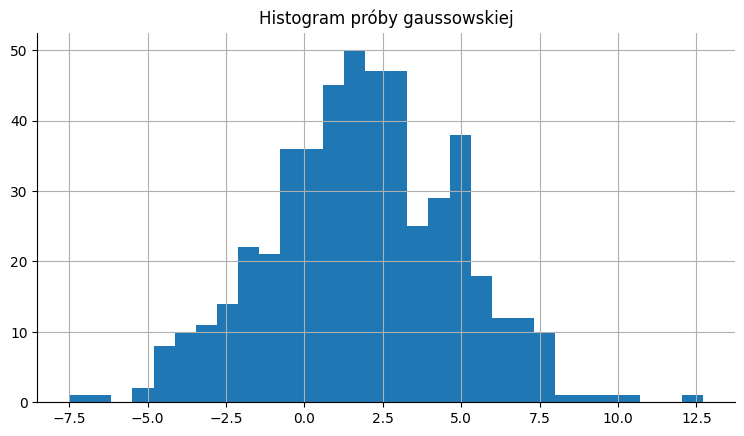

mean, sd, Q1, Q3:
1.848251148396454 2.9663058972012855 -0.12559772113553824 3.9158332218106775
theoretical Q1,Q3: [-0.02346925  4.02346925]


In [5]:
N = 500
m = 2
s = 3

x3 = np.random.normal(loc=m, scale=s, size=N)

plt.hist(x3, bins=30)
plt.title("Histogram próby gaussowskiej")
plt.show()

print("mean, sd, Q1, Q3:")
print(np.mean(x3), np.std(x3, ddof=1), np.quantile(x3, 0.25), np.quantile(x3, 0.75))
from scipy.stats import norm
print("theoretical Q1,Q3:", norm.ppf([0.25, 0.75], loc=m, scale=s))

## TEMAT 1. Błądzenie losowe (random walk)

In [6]:
# czyścimy „stan” – w Pythonie po prostu nadpisujemy zmienne
n = 500
p = 0.5
t = np.arange(1, n+1)

### a) Sposób 1: z rbinom → {0,1} → {−1,+1}

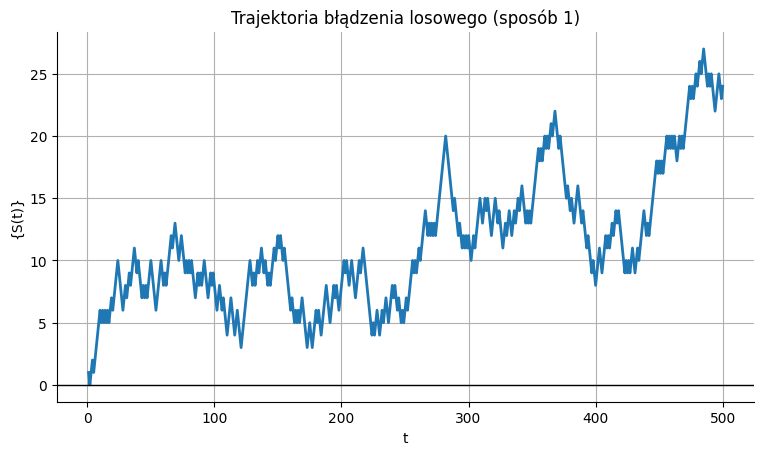

In [7]:
Yt = np.random.binomial(n=1, p=p, size=n)
Xt = 2*Yt - 1
St = np.cumsum(Xt)

plt.plot(t, St, lw=2)
plt.axhline(0, color='k', lw=1)
plt.xlabel("t"); plt.ylabel("{S(t)}")
plt.title("Trajektoria błądzenia losowego (sposób 1)")
plt.show()

### b) Sposób 2: losowanie bezpośrednio z {−1, +1}

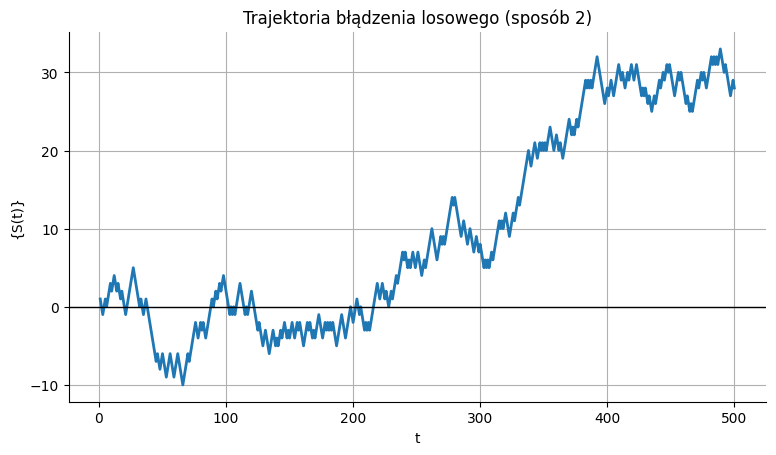

In [8]:
rt = np.random.choice([1, -1], size=n, replace=True, p=[p, 1-p])
S2t = np.cumsum(rt)

plt.plot(t, S2t, lw=2)
plt.axhline(0, color='k', lw=1)
plt.xlabel("t"); plt.ylabel("{S(t)}")
plt.title("Trajektoria błądzenia losowego (sposób 2)")
plt.show()

### Porównanie dwóch trajektorii

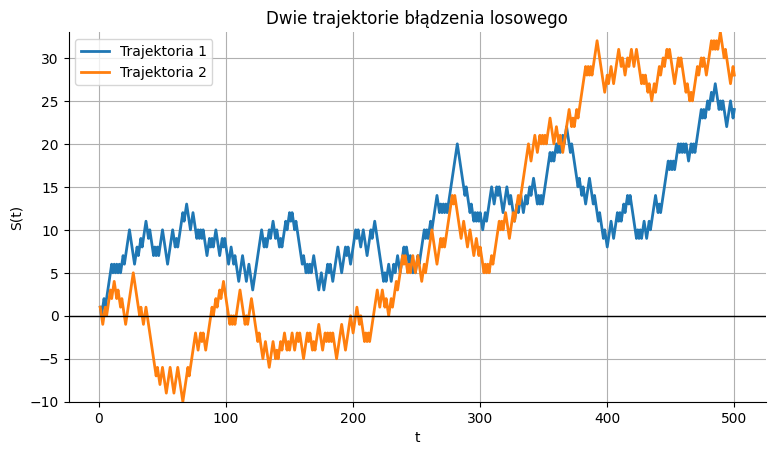

In [9]:
m_ = np.minimum(St.min(), S2t.min())
M_ = np.maximum(St.max(), S2t.max())

plt.plot(t, St, lw=2, label="Trajektoria 1")
plt.plot(t, S2t, lw=2, label="Trajektoria 2")
plt.ylim(m_, M_)
plt.axhline(0, color='k', lw=1)
plt.legend(loc="upper left")
plt.xlabel("t"); plt.ylabel("S(t)")
plt.title("Dwie trajektorie błądzenia losowego")
plt.show()

## TEMAT 1. Proces ceny ze zwrotów {r(t)} (drzewko dwumianowe)

### a) Zwroty arytmetyczne

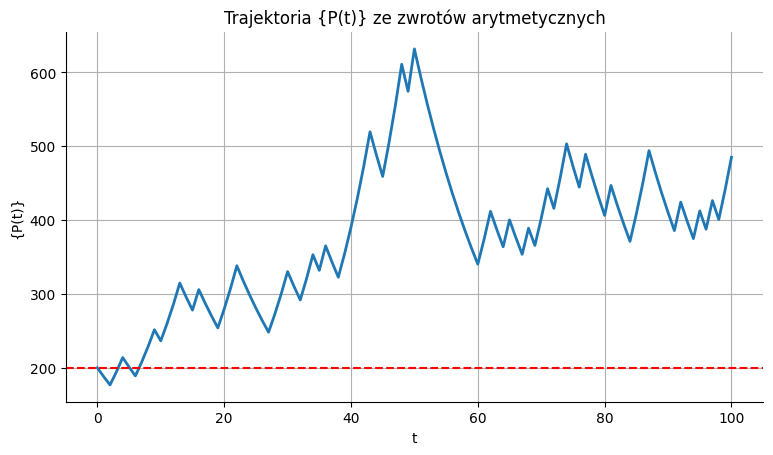

In [21]:
n = 100
p = 0.5
rt = np.random.choice([0.1, -0.06], size=n, replace=True, p=[p, 1-p])
P0 = 200
t = np.arange(0, n+1)

P1t = np.concatenate([[P0], P0 * np.cumprod(1 + rt)])

plt.plot(t, P1t, lw=2)
plt.axhline(P0, ls='--', color='r')
plt.xlabel("t"); plt.ylabel("{P(t)}")
plt.title("Trajektoria {P(t)} ze zwrotów arytmetycznych")
plt.show()

### b) Zwroty logarytmiczne

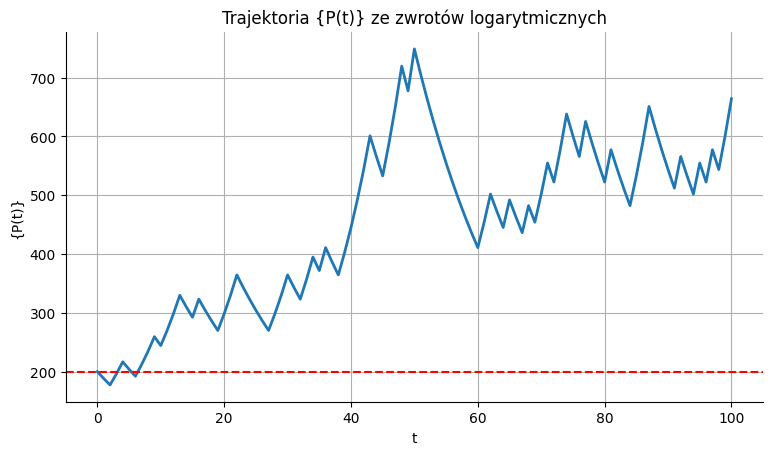

In [22]:
P2t = np.concatenate([[P0], P0 * np.exp(np.cumsum(rt))])

plt.plot(t, P2t, lw=2)
plt.axhline(P0, ls='--', color='r')
plt.xlabel("t"); plt.ylabel("{P(t)}")
plt.title("Trajektoria {P(t)} ze zwrotów logarytmicznych")
plt.show()

**Zadanie 1 (wspólny wykres):**

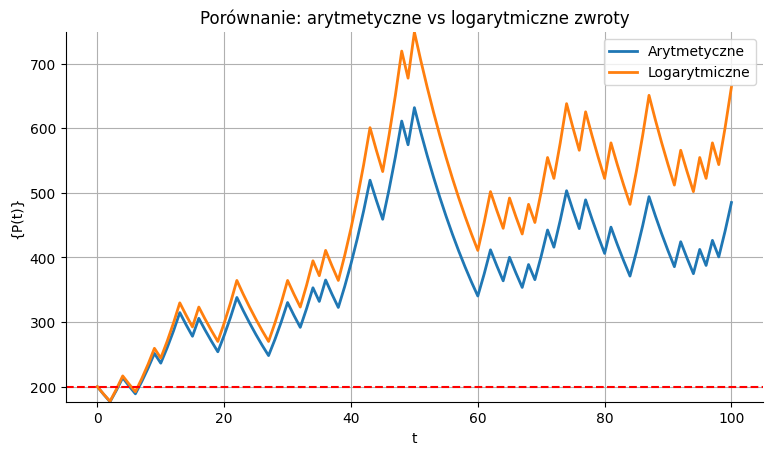

In [23]:
m_ = min(P1t.min(), P2t.min())
M_ = max(P1t.max(), P2t.max())

plt.plot(t, P1t, lw=2, label="Arytmetyczne")
plt.plot(t, P2t, lw=2, label="Logarytmiczne")
plt.ylim(m_, M_)
plt.axhline(P0, ls='--', color='r')
plt.legend()
plt.xlabel("t"); plt.ylabel("{P(t)}")
plt.title("Porównanie: arytmetyczne vs logarytmiczne zwroty")
plt.show()

### c) „Drzewko wielomianowe” – wielopunktowy rozkład zwrotów (arytmetyczne)

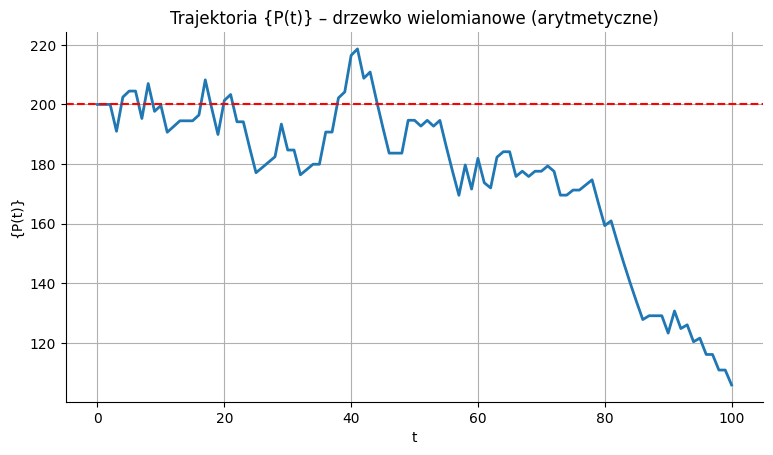

In [13]:
r_  = np.array([-0.045, -0.01, 0, 0.01, 0.06])
ps_ = np.array([0.3, 0.1, 0.2, 0.25, 0.15])
p_  = ps_ / ps_.sum()  # normalizacja

rt_ = np.random.choice(r_, size=n, replace=True, p=p_)
P0 = 200
t = np.arange(0, n+1)

Pt_ = np.concatenate([[P0], P0 * np.cumprod(1 + rt_)])

plt.plot(t, Pt_, lw=2)
plt.axhline(P0, ls='--', color='r')
plt.xlabel("t"); plt.ylabel("{P(t)}")
plt.title("Trajektoria {P(t)} – drzewko wielomianowe (arytmetyczne)")
plt.show()

**Zadanie 2 (logarytmiczne):**

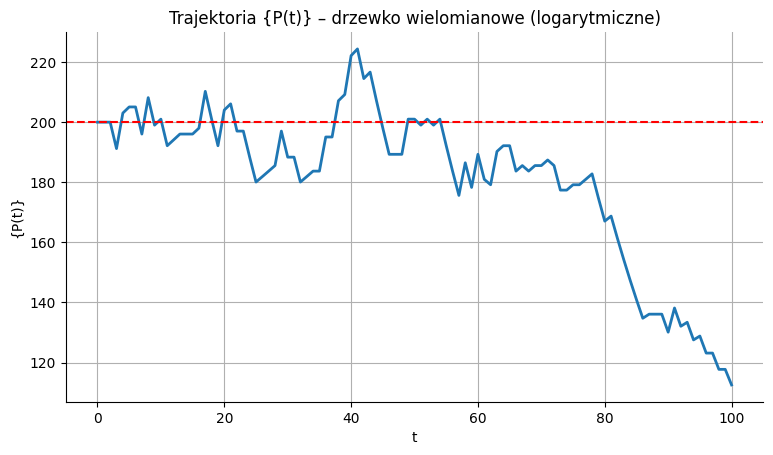

In [14]:
P2t_ = np.concatenate([[P0], P0 * np.exp(np.cumsum(rt_))])

plt.plot(t, P2t_, lw=2)
plt.axhline(P0, ls='--', color='r')
plt.xlabel("t"); plt.ylabel("{P(t)}")
plt.title("Trajektoria {P(t)} – drzewko wielomianowe (logarytmiczne)")
plt.show()

## TEMAT 2. Dane empiryczne, ACF, transformacje, obiekt „ts()” w wersji pandas

> Dane źródłowe: FRED „TTLCON — Total Construction Spending”.
> W R wczytujesz plik `TotalConstruction.txt`. W Pythonie zrobimy analogicznie: zakładam, że plik ma 2 kolumny (np. data i wartość). Jeśli separator to spacja/tab, użyj `delim_whitespace=True`. Jeśli to CSV – zmień na `sep=','`.

### 1) Wczytanie danych, wizualizacja, statystyki

C:\Users\Paweł\AppData\Local\Temp\ipykernel_25468\4202470789.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dane = pd.read_table("TotalConstruction.txt", delim_whitespace=True, header=None, names=["Data", "Wydatki"])


count       215.000000
mean     105405.818605
std       34472.258726
min       51208.000000
25%       78575.500000
50%       97333.000000
75%      124346.000000
max      196973.000000
dtype: float64
sd, skewness, kurtosis(excess): 34472.25872627497 0.821743090426964 -0.015584298519454975


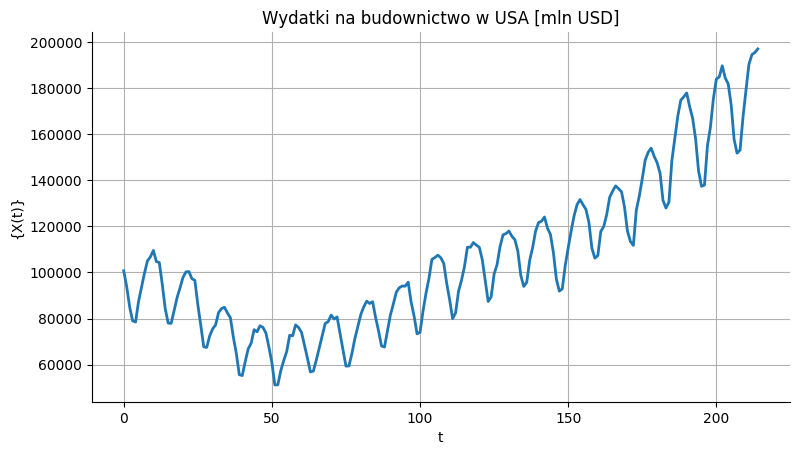

In [24]:
# PRZYKŁAD 1 — plik „kolumna_data kolumna_wydatki” rozdzielony spacją/tabem:
dane = pd.read_table("TotalConstruction.txt", delim_whitespace=True, header=None, names=["Data", "Wydatki"])

# PRZYKŁAD 2 — jeśli masz CSV z nagłówkami:
# dane = pd.read_csv("TotalConstruction.txt")  # i ewentualnie: names=["Data","Wydatki"]

dane.head()
Xt = dane["Wydatki"].astype(float).to_numpy()

print(pd.Series(Xt).describe())
print("sd, skewness, kurtosis(excess):",
      np.std(Xt, ddof=1),
      skew(Xt, bias=False),
      kurtosis(Xt, fisher=True, bias=False))

plt.plot(Xt, lw=2)
plt.xlabel("t"); plt.ylabel("{X(t)}")
plt.title("Wydatki na budownictwo w USA [mln USD]")
plt.show()

### 2) Próbkowy autokorelogram ACF

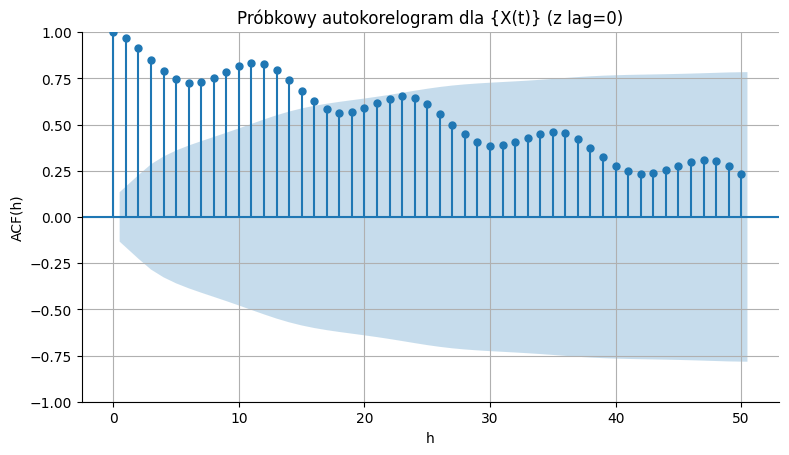

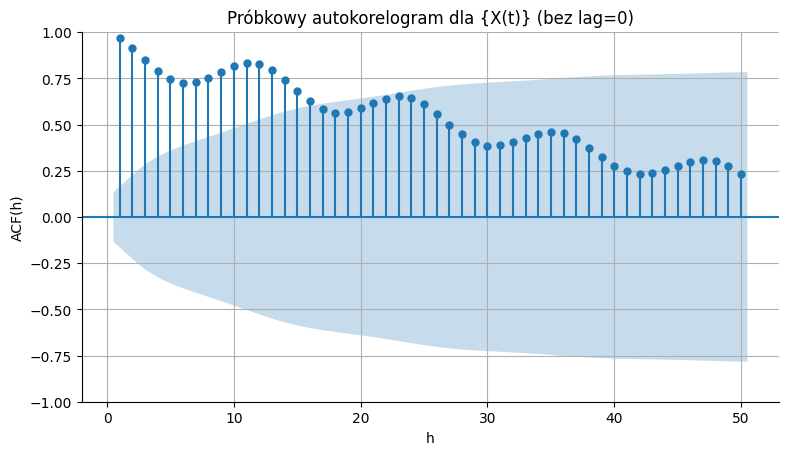

In [25]:
H = 50

# ACF z lagiem 0:
plot_acf(Xt, lags=H)
plt.xlabel("h"); plt.ylabel("ACF(h)")
plt.title("Próbkowy autokorelogram dla {X(t)} (z lag=0)")
plt.show()

# „Lepsza” wersja bez ACF(0) – zero=False usuwa lag 0
plot_acf(Xt, lags=H, zero=False)
plt.xlabel("h"); plt.ylabel("ACF(h)")
plt.title("Próbkowy autokorelogram dla {X(t)} (bez lag=0)")
plt.show()

### 3) Podstawowe transformacje szeregu {X(t)}

#### a) Różnicowanie (przyrosty)

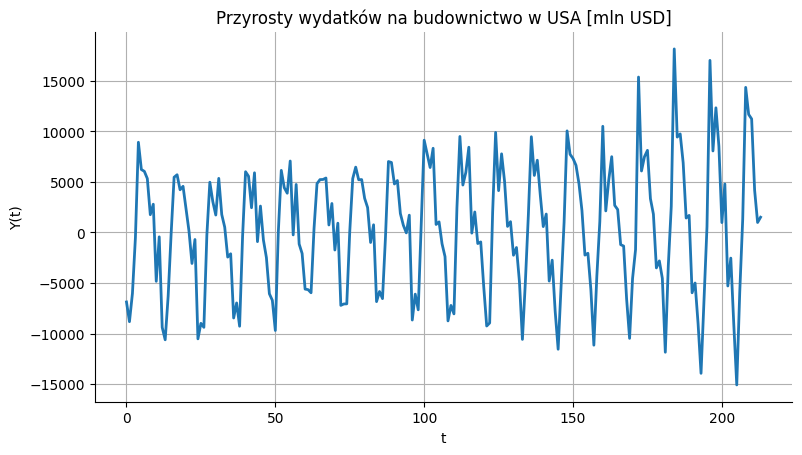

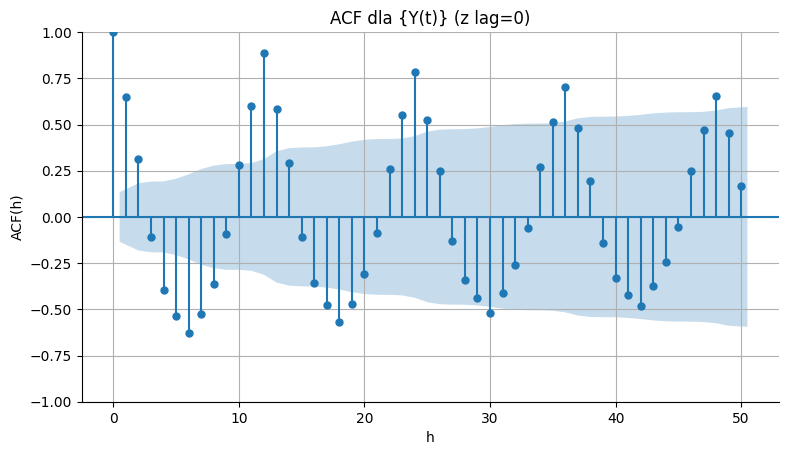

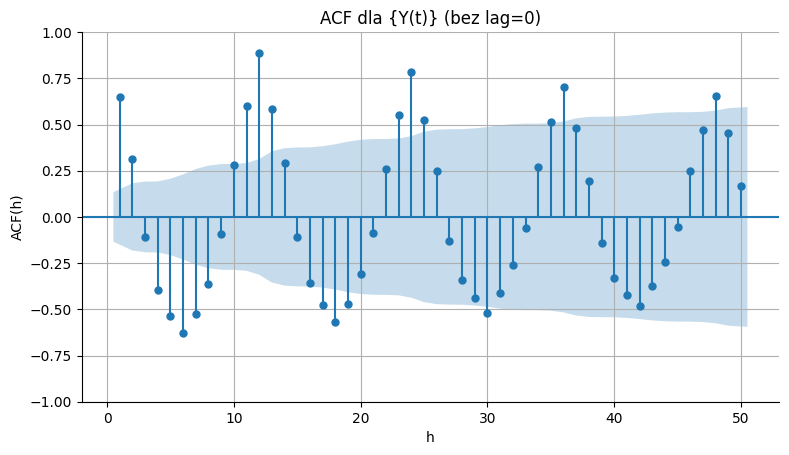

In [26]:
Yt = np.diff(Xt)

plt.plot(Yt, lw=2)
plt.xlabel("t"); plt.ylabel("Y(t)")
plt.title("Przyrosty wydatków na budownictwo w USA [mln USD]")
plt.show()

plot_acf(Yt, lags=H)
plt.xlabel("h"); plt.ylabel("ACF(h)")
plt.title("ACF dla {Y(t)} (z lag=0)")
plt.show()

plot_acf(Yt, lags=H, zero=False)
plt.xlabel("h"); plt.ylabel("ACF(h)")
plt.title("ACF dla {Y(t)} (bez lag=0)")
plt.show()

#### b) Różnicowanie sezonowe z krokiem 12

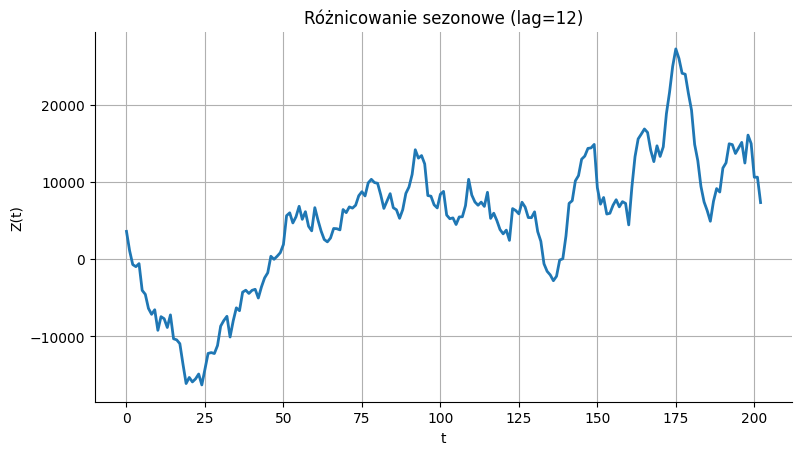

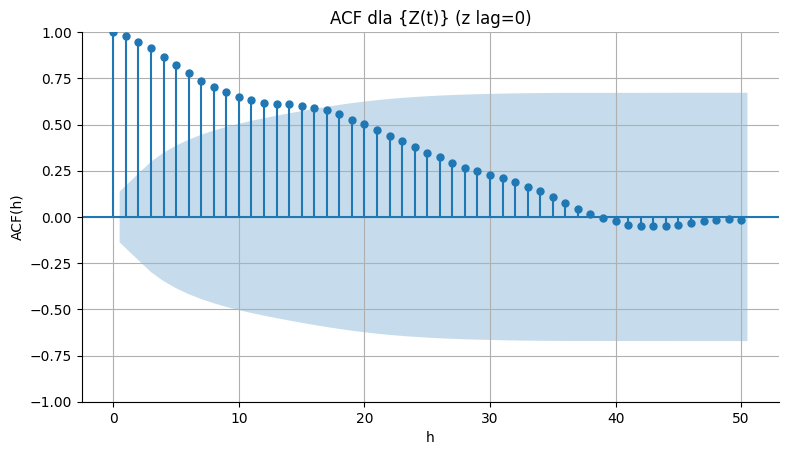

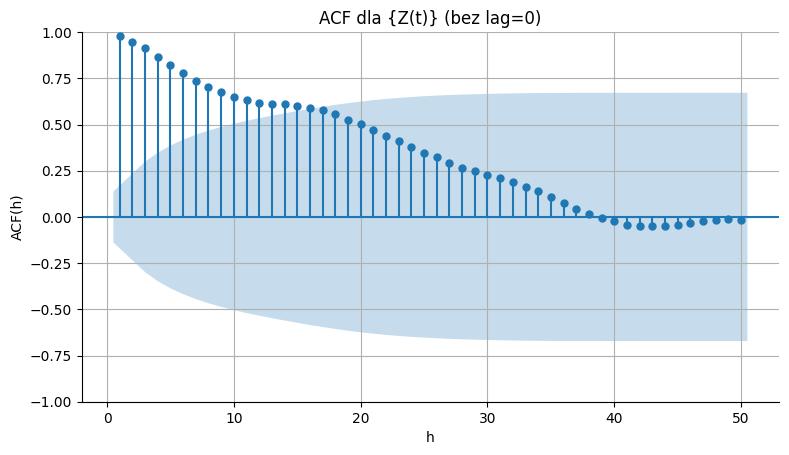

In [27]:
# jeśli Xt jest miesięczne:
Zt = Xt[12:] - Xt[:-12]   # równoważnik diff(Xt, lag=12)

plt.plot(Zt, lw=2)
plt.xlabel("t"); plt.ylabel("Z(t)")
plt.title("Różnicowanie sezonowe (lag=12)")
plt.show()

plot_acf(Zt, lags=H)
plt.xlabel("h"); plt.ylabel("ACF(h)")
plt.title("ACF dla {Z(t)} (z lag=0)")
plt.show()

plot_acf(Zt, lags=H, zero=False)
plt.xlabel("h"); plt.ylabel("ACF(h)")
plt.title("ACF dla {Z(t)} (bez lag=0)")
plt.show()

#### c) Różnicowanie sezonowe + zwykłe łącznie

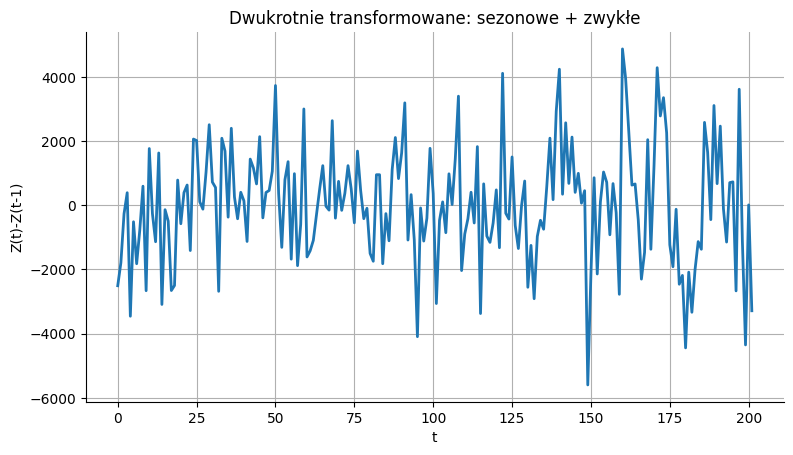

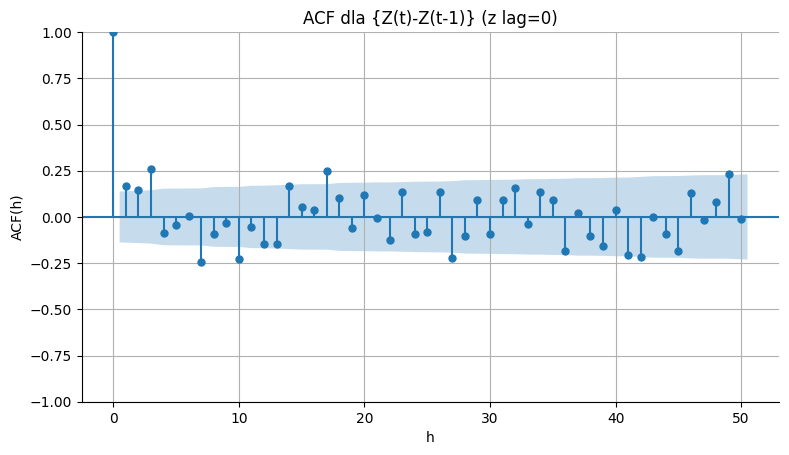

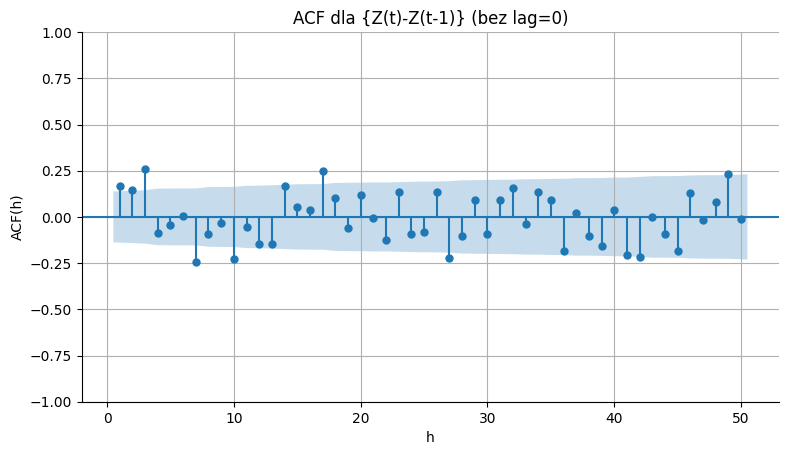

In [28]:
Vt = np.diff(Zt)  # najpierw sezonowe, potem zwykłe (jak w R: diff(diff(Xt,12),1))

plt.plot(Vt, lw=2)
plt.xlabel("t"); plt.ylabel("Z(t)-Z(t-1)")
plt.title("Dwukrotnie transformowane: sezonowe + zwykłe")
plt.show()

plot_acf(Vt, lags=H)
plt.xlabel("h"); plt.ylabel("ACF(h)")
plt.title("ACF dla {Z(t)-Z(t-1)} (z lag=0)")
plt.show()

plot_acf(Vt, lags=H, zero=False)
plt.xlabel("h"); plt.ylabel("ACF(h)")
plt.title("ACF dla {Z(t)-Z(t-1)} (bez lag=0)")
plt.show()

## 4) Obiekt „ts()”: w Pythonie → `pandas.Series` z datami i częstotliwością

Załóżmy, że dane są **miesięczne** i zaczynają się w **październiku 2006** (jak w R `start=c(2006,10), frequency=12`).

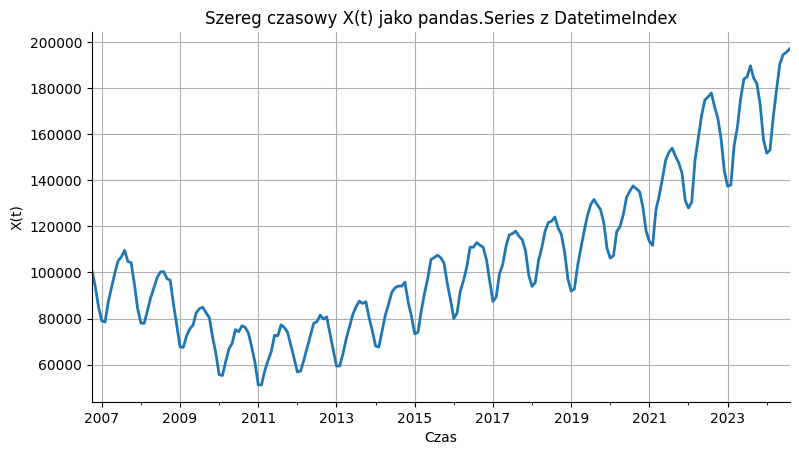

In [29]:
# tworzymy indeks miesięczny startujący 2006-10, długość = len(Xt)
Xts = pd.Series(
    Xt,
    index=pd.date_range(start="2006-10-01", periods=len(Xt), freq="MS")  # MS = Month Start
)

Xts.plot(lw=2)
plt.xlabel("Czas"); plt.ylabel("X(t)")
plt.title("Szereg czasowy X(t) jako pandas.Series z DatetimeIndex")
plt.show()

### „Wycinanie” (window)

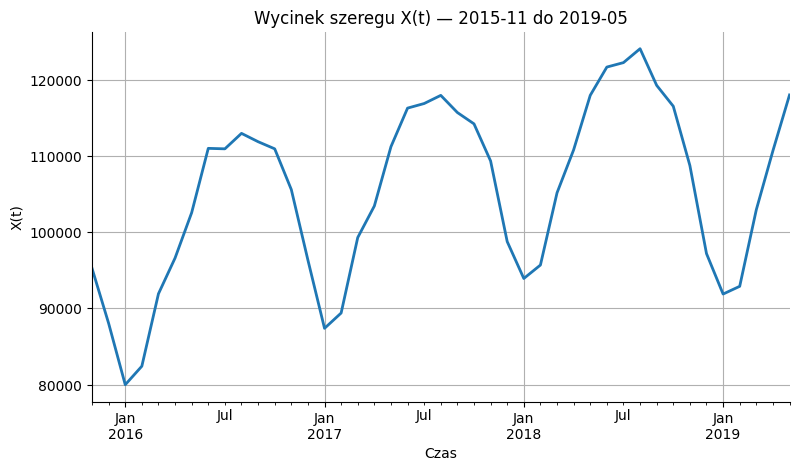

In [30]:
# Wycinanie: od 2015-11 do 2019-05 (włącznie)
Xts2 = Xts.loc["2015-11":"2019-05"]

Xts2.plot(lw=2)
plt.xlabel("Czas"); plt.ylabel("X(t)")
plt.title("Wycinek szeregu X(t) — 2015-11 do 2019-05")
plt.show()

### Dane tylko z marca rok po roku

In [31]:
Xts_march = Xts[Xts.index.month == 3]
print(Xts_march)
print(Xts_march.describe())

2007-03-01     87421.0
2008-03-01     83384.0
2009-03-01     72448.0
2010-03-01     61274.0
2011-03-01     57374.0
2012-03-01     62056.0
2013-03-01     64790.0
2014-03-01     74653.0
2015-03-01     83158.0
2016-03-01     91924.0
2017-03-01     99300.0
2018-03-01    105159.0
2019-03-01    102949.0
2020-03-01    117793.0
2021-03-01    127095.0
2022-03-01    148686.0
2023-03-01    154961.0
2024-03-01    167395.0
dtype: float64
count        18.000000
mean      97878.888889
std       33536.303958
min       57374.000000
25%       72999.250000
50%       89672.500000
75%      114634.500000
max      167395.000000
dtype: float64
